In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 1000

In [2]:
csv_save_dir = 'output_csvs_NEW_AUG_2018'
if not os.path.exists(csv_save_dir):
    os.makedirs(csv_save_dir)

In [3]:
%%time

# Read information for the new records
records = pd.read_csv('new-citations-NEWAUG2018.tsv', sep='\t', header=None)
records.columns = ['recID', 'oldRef', 'newRef', 'metaData']

print('Total Records: {}'.format(len(records)))

Total Records: 31175879
CPU times: user 3min 9s, sys: 10.9 s, total: 3min 20s
Wall time: 3min 30s


In [4]:
# Read the new citation counts
labs = pd.read_csv('new-citation-counts-NEWAUG2018.tsv', sep='\t', header=None)
labs.columns = ['recID', 'Citation_Difference']
# Citation_Difference is actually citation count but is used here for ease later when subtracting

# Index by recIDs
labs_indexed = labs.set_index('recID')

In [5]:
# Read the legacy citation counts
legacy = pd.read_csv('old-citation-counts-AUG2018.csv', sep=',')
legacy.columns = ['recID', 'Citation_Difference', 'Timestamp']
# Citation_Difference is actually citation count but is used here for ease later when subtracting
legacy = legacy.drop(['Timestamp'], axis='columns')

# Index by recrod IDs
legacy_indexed = legacy.set_index('recID')

In [6]:
# Compute the difference in citation counts between Labs and Legacy
diff = labs_indexed - legacy_indexed

In [7]:
# Filter out the NaNs
is_nan = diff.Citation_Difference.isna()
NaN_entries = diff[is_nan]

print('{} articles are differently indexed between the legacy and labs records and have no correspondence'.format(len(NaN_entries)))

11239 articles are differently indexed between the legacy and labs records and have no correspondence


In [8]:
# Filter the valid entries
is_valid = ~diff.Citation_Difference.isna()
valid_diff = diff[is_valid]

In [9]:
# Get the articles which have lost citations
lost = valid_diff.Citation_Difference < 0
lost_citations = valid_diff[lost]

# Sort the list
lost_citations = lost_citations.sort_values('Citation_Difference')

In [10]:
# Get the articles which have gained citations
gained = valid_diff.Citation_Difference > 0
gained_citations = valid_diff[gained]

# Sort the list
gained_citations = gained_citations.sort_values('Citation_Difference', ascending=False)

In [11]:
# Get the counts for absolute differences in citation numbers
abs_diff = np.abs(valid_diff)
abs_diff = abs_diff.sort_values('Citation_Difference', ascending=False)

# Get just the zero difference entries
zero_diff = abs_diff.Citation_Difference == 0
zero_diff = abs_diff[zero_diff]

# Filter out the zero difference entries
non_zero_diff = abs_diff.Citation_Difference != 0
abs_diff = abs_diff[non_zero_diff]

In [12]:
# Initialize extended DataFrames for the differences
lost_citations_ext = lost_citations
gained_citations_ext = gained_citations
abs_diff_ext = abs_diff

# For lost citations
lost_citations_ext['Legacy_Count'] = legacy_indexed.loc[lost_citations.index]
lost_citations_ext['Labs_Count'] = labs_indexed.loc[lost_citations.index]

# For gained citations
gained_citations_ext['Legacy_Count'] = legacy_indexed.loc[gained_citations.index]
gained_citations_ext['Labs_Count'] = labs_indexed.loc[gained_citations.index]

# For absolute difference in citation counts
abs_diff_ext['Legacy_Count'] = legacy_indexed.loc[abs_diff.index]
abs_diff_ext['Labs_Count'] = labs_indexed.loc[abs_diff.index]

### Incorporate "invalid/NaN" entries

In [13]:
invalid_records = NaN_entries.index

In [14]:
legacy_NaNs = np.intersect1d(legacy_indexed.index, invalid_records)
legacy_only = legacy_indexed.loc[list(legacy_NaNs)]
len(legacy_only)

8945

In [15]:
labs_NaNs = np.intersect1d(labs_indexed.index, invalid_records)
labs_only = labs_indexed.loc[list(labs_NaNs)]
len(labs_only)

2294

In [16]:
# PLEASE RUN ONLY ONCE TO AVOID MULTIPLE APPENDS

# Initialize extended DataFrames for the "invalid" differences
legacy_only_ext = legacy_only
labs_only_ext = labs_only

# For legacy_only (Lost citations)
legacy_only_ext['Legacy_Count'] = legacy_only.Citation_Difference
legacy_only_ext['Labs_Count'] = 0


# For labs_only (Gained citations)
labs_only_ext['Legacy_Count'] = 0
labs_only_ext['Labs_Count'] = labs_only.Citation_Difference

# Append to the appropriate categories
abs_diff_ext = abs_diff_ext.append(legacy_only_ext)
abs_diff_ext = abs_diff_ext.append(labs_only_ext)
abs_diff_ext = abs_diff_ext.sort_values('Citation_Difference', ascending=False)

gained_citations_ext = gained_citations_ext.append(labs_only_ext)
gained_citations_ext = gained_citations_ext.sort_values('Citation_Difference', ascending=False)

legacy_only_ext.Citation_Difference = legacy_only_ext.Citation_Difference * -1
lost_citations_ext = lost_citations_ext.append(legacy_only_ext)
lost_citations_ext = lost_citations_ext.sort_values('Citation_Difference')

In [17]:
# Save the citation difference DataFrames to CSV Files
lost_citations_ext.to_csv(os.path.join(csv_save_dir, 'lost_citations_prev.csv'))
gained_citations_ext.to_csv(os.path.join(csv_save_dir, 'gained_citations_prev.csv'))
abs_diff_ext.to_csv(os.path.join(csv_save_dir, 'overall_difference_prev.csv'))

### Investigate records which were not imported

In [54]:
diff_recids = list(abs_diff_ext.index)
def check_if_record_exists(recid):
    url = 'http://localhost:5000/api/literature/'+str(recid)
    json_data = requests.get(url).json()
    if json_data.get('status') == 404:
        return False
    else:
        return True

In [55]:
exist_list = []
not_exist_list = []
for recid in diff_recids:
    if check_if_record_exists(recid):
        exist_list.append(recid)
    else:
        not_exist_list.append(recid)

In [75]:
len(exist_list)

78253

In [57]:
len(not_exist_list)

118

#### Filter out records which were not imported

In [76]:
abs_diff_ext = abs_diff_ext.reindex(exist_list)
lost_citations_ext = lost_citations_ext.reindex(exist_list)
lost_citations_ext = lost_citations_ext[~lost_citations_ext.Citation_Difference.isna()]
gained_citations_ext = gained_citations_ext.reindex(exist_list)
gained_citations_ext = gained_citations_ext[~gained_citations_ext.Citation_Difference.isna()]

### Some useful statistics

In [78]:
# Indicate Number of articles with zero differences in citation counts
num_cited_legacy = len(legacy.index.unique())
num_cited_labs = len(labs.index.unique())
num_unique_articles = len(records.recID.unique())
total_unique_cited_articles = len(np.union1d(legacy_indexed.index, labs_indexed.index)) - len(not_exist_list)
print('Total number of unique Cited articles as per legacy: {}'.format(num_cited_legacy))
print('Total number of unique Cited articles as per Labs: {}'.format(num_cited_labs))
print('Union of the above two - Total unique cited articles: {}'.format(total_unique_cited_articles))
print('\nTotal Number of Unique Articles which cite other papers: {}\n'.format(num_unique_articles))

num_zero_diff = valid_diff.Citation_Difference.value_counts()[0]
percent_zero_diff = num_zero_diff / total_unique_cited_articles * 100
print('Number of Cited articles with zero difference: {}'.format(num_zero_diff))
print('Percentage of Cited articles with zero difference: {0:0.2f} %'.format(percent_zero_diff))

Total number of unique Cited articles as per legacy: 776108
Total number of unique Cited articles as per Labs: 769457
Union of the above two - Total unique cited articles: 778284

Total Number of Unique Articles which cite other papers: 964161

Number of Cited articles with zero difference: 700031
Percentage of Cited articles with zero difference: 89.95 %


In [79]:
# Percentage Differences for absolute differences
abs_diff_counts = abs_diff_ext.Citation_Difference.value_counts()
print('Total Number of article with changes in citation counts in Labs: {}'.format(len(abs_diff_ext)))

print('\nNumber of articles with changes in Citation Counts in Labs')
print(abs_diff_counts[:5])

print('\nPercent (%) of Citation Counts Difference in Labs')
print(abs_diff_counts[:5] / total_unique_cited_articles * 100)

num_grt5 = sum(abs_diff_counts[6:])
percent_grt5 = num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with difference greater than 5 - Percentage: {} %\n'.format(num_grt5, percent_grt5))

Total Number of article with changes in citation counts in Labs: 78253

Number of articles with changes in Citation Counts in Labs
1.0    60989
2.0     8764
3.0     2964
4.0     1404
5.0      810
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Difference in Labs
1.0    7.836343
2.0    1.126067
3.0    0.380838
4.0    0.180397
5.0    0.104075
Name: Citation_Difference, dtype: float64

Total 3322 records with difference greater than 5 - Percentage: 0.4268364761449548 %



In [80]:
# Percentage Differences for lost citations
lost_citations_count = lost_citations_ext.Citation_Difference.value_counts()
print('Total Number of article with loss in citation counts in Labs: {}'.format(len(lost_citations_ext)))

print('\nNumber of articles losing Citation Counts in Labs')
print(lost_citations_count[:-5])

lost_percent_diff = lost_citations_count/ total_unique_cited_articles * 100
print('\nPercent (%) of Citation Counts Lost in Labs')
print(lost_percent_diff[:-5])

lost_grt5 = sum(lost_citations_count[-6:])
lost_percent_grt5 = lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with lost citations greater than 5 - Percentage: {} %\n'.format(lost_grt5, lost_percent_grt5))

Total Number of article with loss in citation counts in Labs: 56166

Number of articles losing Citation Counts in Labs
-1.0    43149
-2.0     6564
-3.0     2160
-4.0     1017
-5.0      609
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Lost in Labs
-1.0    5.544120
-2.0    0.843394
-3.0    0.277534
-4.0    0.130672
-5.0    0.078249
Name: Citation_Difference, dtype: float64

Total 2667 records with lost citations greater than 5 - Percentage: 0.3426769662488243 %



In [81]:
# Percentage Differences for gained citations
gained_citations_count = gained_citations_ext.Citation_Difference.value_counts()
print('Total Number of article with gain in citation counts in Labs: {}'.format(len(gained_citations_ext)))

print('\nNumber of articles gaining Citation Counts in Labs')
print(gained_citations_count[:5])

gained_percent_diff = gained_citations_count/ total_unique_cited_articles * 100
print('\nPercent (%) of Citation Counts Gained in Labs')
print(gained_percent_diff[:5])


gained_grt5 = sum(gained_citations_count[6:])
gained_percent_grt5 = gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with gained citations greater than 5 - Percentage: {} %\n'.format(gained_grt5, gained_percent_grt5))

Total Number of article with gain in citation counts in Labs: 22087

Number of articles gaining Citation Counts in Labs
1.0    17840
2.0     2200
3.0      804
4.0      387
5.0      201
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Gained in Labs
1.0    2.292222
2.0    0.282673
3.0    0.103304
4.0    0.049725
5.0    0.025826
Name: Citation_Difference, dtype: float64

Total 655 records with gained citations greater than 5 - Percentage: 0.08415950989613047 %



### Analyze "Core-ness" of the records with citation differences

In [82]:
core_list = pd.read_csv('inspire_core_list_NEWAUG2018.txt', sep='\n', header=None)

##### For Absolute differences

In [83]:
core_articles_with_diff = np.intersect1d(abs_diff_ext.index, core_list[0].unique())
non_core_articles_with_diff = np.setxor1d(core_articles_with_diff, abs_diff_ext.index)

print('Of {} records with citation differences, {} are CORE and {} are Non-Core'.format(len(abs_diff_ext), len(core_articles_with_diff), len(non_core_articles_with_diff)))

core_changed_citations = abs_diff_ext.loc[list(core_articles_with_diff)].Citation_Difference.sum()
non_core_changed_citations = abs_diff_ext.loc[list(non_core_articles_with_diff)].Citation_Difference.sum()

print('Of the above, CORE records have {} different number of citations while Non-Core articles have {} different number of citations'.format(core_changed_citations, non_core_changed_citations))

core_articles_with_diff_ext = abs_diff_ext.loc[core_articles_with_diff].sort_values('Citation_Difference', ascending=False)
non_core_articles_with_diff_ext = abs_diff_ext.loc[non_core_articles_with_diff].sort_values('Citation_Difference', ascending=False)

Of 78253 records with citation differences, 52599 are CORE and 25654 are Non-Core
Of the above, CORE records have 129175.0 different number of citations while Non-Core articles have 47337.0 different number of citations


In [84]:
# For Core
core_diff_counts = core_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of CORE articles with changes in Citation Counts in Labs')
print(core_diff_counts[:5])

print('\nPercent (%) of CORE Citation Counts Difference in Labs')
print(core_diff_counts[:5] / total_unique_cited_articles * 100)

core_num_grt5 = sum(core_diff_counts[6:])
core_percent_grt5 = core_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} CORE records with difference greater than 5 - Percentage: {} %\n'.format(core_num_grt5, core_percent_grt5))


Number of CORE articles with changes in Citation Counts in Labs
1.0    40306
2.0     5963
3.0     2094
4.0     1032
5.0      581
Name: Citation_Difference, dtype: int64

Percent (%) of CORE Citation Counts Difference in Labs
1.0    5.178829
2.0    0.766173
3.0    0.269053
4.0    0.132599
5.0    0.074651
Name: Citation_Difference, dtype: float64

Total 2623 CORE records with difference greater than 5 - Percentage: 0.33702350298862627 %



In [85]:
# For Non-Core
non_core_diff_counts = non_core_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of non-CORE articles with changes in Citation Counts in Labs')
print(non_core_diff_counts[:5])

print('\nPercent (%) of non-CORE Citation Counts Difference in Labs')
print(non_core_diff_counts[:5] / total_unique_cited_articles * 100)

non_core_num_grt5 = sum(non_core_diff_counts[6:])
non_core_percent_grt5 = non_core_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-CORE records with difference greater than 5 - Percentage: {} %\n'.format(non_core_num_grt5, non_core_percent_grt5))


Number of non-CORE articles with changes in Citation Counts in Labs
1.0    20683
2.0     2801
3.0      870
4.0      372
5.0      229
Name: Citation_Difference, dtype: int64

Percent (%) of non-CORE Citation Counts Difference in Labs
1.0    2.657513
2.0    0.359894
3.0    0.111784
4.0    0.047797
5.0    0.029424
Name: Citation_Difference, dtype: float64

Total 699 non-CORE records with difference greater than 5 - Percentage: 0.08981297315632854 %



##### For Lost Citations

In [86]:
core_articles_with_loss = np.intersect1d(lost_citations_ext.index, core_list[0].unique())
non_core_articles_with_loss = np.setxor1d(core_articles_with_loss, lost_citations_ext.index)

print('Of {} records with citation losses, {} are CORE and {} are Non-Core'.format(len(lost_citations_ext), len(core_articles_with_loss), len(non_core_articles_with_loss)))

core_lost_citations = lost_citations_ext.loc[list(core_articles_with_loss)].Citation_Difference.sum()
non_core_lost_citations = lost_citations_ext.loc[list(non_core_articles_with_loss)].Citation_Difference.sum()

print('Of the above, CORE records have lost {} citations while Non-Core articles have lost {} citations'.format(abs(core_lost_citations), abs(non_core_lost_citations)))

core_articles_with_loss_ext = lost_citations_ext.loc[core_articles_with_loss].sort_values('Citation_Difference')
non_core_articles_with_loss_ext = lost_citations_ext.loc[non_core_articles_with_loss].sort_values('Citation_Difference')

Of 56166 records with citation losses, 35904 are CORE and 20262 are Non-Core
Of the above, CORE records have lost 99033.0 citations while Non-Core articles have lost 39362.0 citations


In [87]:
# For Core
core_lost_counts = core_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of CORE articles with loss in Citation Counts in Labs')
print(core_lost_counts[:-5])

print('\nPercent (%) of CORE Citation Lost in Labs')
print(core_lost_counts[:-5] / total_unique_cited_articles * 100)

core_lost_grt5 = sum(core_lost_counts[-6:])
core_lost_percent_grt5 = core_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} CORE records with loss greater than 5 - Percentage: {} %\n'.format(core_lost_grt5, core_lost_percent_grt5))


Number of CORE articles with loss in Citation Counts in Labs
-1.0    27140
-2.0     4180
-3.0     1400
-4.0      699
-5.0      412
Name: Citation_Difference, dtype: int64

Percent (%) of CORE Citation Lost in Labs
-1.0    3.487159
-2.0    0.537079
-3.0    0.179883
-4.0    0.089813
-5.0    0.052937
Name: Citation_Difference, dtype: float64

Total 2073 CORE records with loss greater than 5 - Percentage: 0.2663552122361503 %



In [88]:
# For Non-Core
non_core_lost_counts = non_core_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of non-CORE articles with loss in Citation Counts in Labs')
print(non_core_lost_counts[:-5])

print('\nPercent (%) of non-CORE Citation Counts Lost in Labs')
print(non_core_lost_counts[:-5] / total_unique_cited_articles * 100)

non_core_lost_grt5 = sum(non_core_lost_counts[-6:])
non_core_lost_percent_grt5 = non_core_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Non-CORE records with loss greater than 5 - Percentage: {} %\n'.format(non_core_lost_grt5, non_core_lost_percent_grt5))


Number of non-CORE articles with loss in Citation Counts in Labs
-1.0    16009
-2.0     2384
-3.0      760
-4.0      318
-5.0      197
Name: Citation_Difference, dtype: int64

Percent (%) of non-CORE Citation Counts Lost in Labs
-1.0    2.056961
-2.0    0.306315
-3.0    0.097651
-4.0    0.040859
-5.0    0.025312
Name: Citation_Difference, dtype: float64

Total 594 Non-CORE records with loss greater than 5 - Percentage: 0.07632175401267403 %



##### For Gained Citations

In [89]:
core_articles_with_gain = np.intersect1d(gained_citations_ext.index, core_list[0].unique())
non_core_articles_with_gain = np.setxor1d(core_articles_with_gain, gained_citations_ext.index)

print('Of {} records with citation gains, {} are CORE and {} are Non-Core'.format(len(gained_citations_ext), len(core_articles_with_gain), len(non_core_articles_with_gain)))

core_gained_citations = gained_citations_ext.loc[list(core_articles_with_gain)].Citation_Difference.sum()
non_core_gained_citations = gained_citations_ext.loc[list(non_core_articles_with_gain)].Citation_Difference.sum()

print('Of the above, CORE records have gained {} citations while Non-Core articles have gained {} citations'.format(abs(core_gained_citations), abs(non_core_gained_citations)))

core_articles_with_gain_ext = gained_citations_ext.loc[core_articles_with_gain].sort_values('Citation_Difference', ascending=False)
non_core_articles_with_gain_ext = gained_citations_ext.loc[non_core_articles_with_gain].sort_values('Citation_Difference', ascending=False)

Of 22087 records with citation gains, 16695 are CORE and 5392 are Non-Core
Of the above, CORE records have gained 30142.0 citations while Non-Core articles have gained 7975.0 citations


In [90]:
# For Core
core_gained_counts = core_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of CORE articles with gain in Citation Counts in Labs')
print(core_gained_counts[:5])

print('\nPercent (%) of CORE Citation Gained in Labs')
print(core_gained_counts[:5] / total_unique_cited_articles * 100)

core_gained_grt5 = sum(core_gained_counts[6:])
core_gained_percent_grt5 = core_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} CORE records with gain greater than 5 - Percentage: {} %\n'.format(core_gained_grt5, core_gained_percent_grt5))


Number of CORE articles with gain in Citation Counts in Labs
1.0    13166
2.0     1783
3.0      694
4.0      333
5.0      169
Name: Citation_Difference, dtype: int64

Percent (%) of CORE Citation Gained in Labs
1.0    1.691670
2.0    0.229094
3.0    0.089171
4.0    0.042786
5.0    0.021714
Name: Citation_Difference, dtype: float64

Total 550 CORE records with gain greater than 5 - Percentage: 0.07066829075247597 %



In [91]:
# For Non-Core
non_core_gained_counts = non_core_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of non-CORE articles with gain in Citation Counts in Labs')
print(non_core_gained_counts[:5])

print('\nPercent (%) of non-CORE Citation Counts Gained in Labs')
print(non_core_gained_counts[:5] / total_unique_cited_articles * 100)

non_core_gained_grt5 = sum(non_core_gained_counts[6:])
non_core_gained_percent_grt5 = non_core_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-CORE records with gain greater than 5 - Percentage: {} %\n'.format(non_core_gained_grt5, non_core_gained_percent_grt5))


Number of non-CORE articles with gain in Citation Counts in Labs
1.0    4674
2.0     417
3.0     110
4.0      54
5.0      32
Name: Citation_Difference, dtype: int64

Percent (%) of non-CORE Citation Counts Gained in Labs
1.0    0.600552
2.0    0.053579
3.0    0.014134
4.0    0.006938
5.0    0.004112
Name: Citation_Difference, dtype: float64

Total 105 non-CORE records with gain greater than 5 - Percentage: 0.013491219143654502 %



##### For citations with zero difference

In [92]:
core_articles_with_zero_diff = np.intersect1d(zero_diff.index, core_list[0].unique())
non_core_articles_with_zero_diff = np.setxor1d(core_articles_with_zero_diff, zero_diff.index)

print('Of {} records with 0 citation differences, {} are CORE and {} are Non-Core'.format(len(zero_diff), len(core_articles_with_zero_diff), len(non_core_articles_with_zero_diff)))

Of 700031 records with 0 citation differences, 440089 are CORE and 259942 are Non-Core


### Analyze by "citeable"

In [93]:
citeable_list = pd.read_csv('inspire_citeable_list_NEWAUG2018.txt', sep='\n', header=None)

##### For Absolute differences

In [94]:
citeable_articles_with_diff = np.intersect1d(abs_diff_ext.index, citeable_list[0].unique())
non_citeable_articles_with_diff = np.setxor1d(citeable_articles_with_diff, abs_diff_ext.index)

print('Of {} records with citation differences, {} are Citeable and {} are Non-Citeable'.format(len(abs_diff_ext), len(citeable_articles_with_diff), len(non_citeable_articles_with_diff)))

citeable_changed_citations = abs_diff_ext.loc[list(citeable_articles_with_diff)].Citation_Difference.sum()
non_citeable_changed_citations = abs_diff_ext.loc[list(non_citeable_articles_with_diff)].Citation_Difference.sum()

print('Of the above, Citeable records have {} number of citations while Non-Citeable articles have {} different number of citations'.format(citeable_changed_citations, non_citeable_changed_citations))

citeable_articles_with_diff_ext = abs_diff_ext.loc[citeable_articles_with_diff].sort_values('Citation_Difference', ascending=False)
non_citeable_articles_with_diff_ext = abs_diff_ext.loc[non_citeable_articles_with_diff].sort_values('Citation_Difference', ascending=False)

Of 78253 records with citation differences, 74730 are Citeable and 3523 are Non-Citeable
Of the above, Citeable records have 164519.0 number of citations while Non-Citeable articles have 11993.0 different number of citations


In [95]:
# For Citeable
citeable_diff_counts = citeable_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of Citeable articles with changes in Citation Counts in Labs')
print(citeable_diff_counts[:5])

print('\nPercent (%) of Citeable Citation Counts Difference in Labs')
print(citeable_diff_counts[:5] / total_unique_cited_articles * 100)

citeable_num_grt5 = sum(citeable_diff_counts[6:])
citeable_percent_grt5 = citeable_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Citeable records with difference greater than 5 - Percentage: {} %\n'.format(citeable_num_grt5, citeable_percent_grt5))


Number of Citeable articles with changes in Citation Counts in Labs
1.0    58552
2.0     8289
3.0     2778
4.0     1305
5.0      739
Name: Citation_Difference, dtype: int64

Percent (%) of Citeable Citation Counts Difference in Labs
1.0    7.523218
2.0    1.065035
3.0    0.356939
4.0    0.167677
5.0    0.094952
Name: Citation_Difference, dtype: float64

Total 3067 Citeable records with difference greater than 5 - Percentage: 0.39407208679607963 %



In [96]:
# For Non-Citeable
non_citeable_diff_counts = non_citeable_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of non-Citeable articles with changes in Citation Counts in Labs')
print(non_citeable_diff_counts[:5])

print('\nPercent (%) of non-Citeable Citation Counts Difference in Labs')
print(non_citeable_diff_counts[:5] / total_unique_cited_articles * 100)

non_citeable_num_grt5 = sum(non_citeable_diff_counts[6:])
non_citeable_percent_grt5 = non_citeable_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-Citeable records with difference greater than 5 - Percentage: {} %\n'.format(non_citeable_num_grt5, non_citeable_percent_grt5))


Number of non-Citeable articles with changes in Citation Counts in Labs
1.0    2437
2.0     475
3.0     186
4.0      99
5.0      71
Name: Citation_Difference, dtype: int64

Percent (%) of non-Citeable Citation Counts Difference in Labs
1.0    0.313125
2.0    0.061032
3.0    0.023899
4.0    0.012720
5.0    0.009123
Name: Citation_Difference, dtype: float64

Total 216 non-Citeable records with difference greater than 5 - Percentage: 0.027753365095517832 %



##### For Lost Citations

In [97]:
citeable_articles_with_loss = np.intersect1d(lost_citations_ext.index, citeable_list[0].unique())
non_citeable_articles_with_loss = np.setxor1d(citeable_articles_with_loss, lost_citations_ext.index)

print('Of {} records with citation losses, {} are Citeable and {} are Non-Citeable'.format(len(lost_citations_ext), len(citeable_articles_with_loss), len(non_citeable_articles_with_loss)))

citeable_lost_citations = lost_citations_ext.loc[list(citeable_articles_with_loss)].Citation_Difference.sum()
non_citeable_lost_citations = lost_citations_ext.loc[list(non_citeable_articles_with_loss)].Citation_Difference.sum()

print('Of the above, Citeable records have lost {} citations while Non-Citeable articles have lost {} citations'.format(abs(citeable_lost_citations), abs(non_citeable_lost_citations)))

citeable_articles_with_loss_ext = lost_citations_ext.loc[citeable_articles_with_loss].sort_values('Citation_Difference')
non_citeable_articles_with_loss_ext = lost_citations_ext.loc[non_citeable_articles_with_loss].sort_values('Citation_Difference')

Of 56166 records with citation losses, 53591 are Citeable and 2575 are Non-Citeable
Of the above, Citeable records have lost 128040.0 citations while Non-Citeable articles have lost 10355.0 citations


In [98]:
# For Citeable
citeable_lost_counts = citeable_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of Citeable articles with loss in Citation Counts in Labs')
print(citeable_lost_counts[:-5])

print('\nPercent (%) of Citeable Citation Lost in Labs')
print(citeable_lost_counts[:-5] / total_unique_cited_articles * 100)

citeable_lost_grt5 = sum(citeable_lost_counts[-6:])
citeable_lost_percent_grt5 = citeable_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Citeable records with loss greater than 5 - Percentage: {} %\n'.format(citeable_lost_grt5, citeable_lost_percent_grt5))


Number of Citeable articles with loss in Citation Counts in Labs
-1.0    41435
-2.0     6214
-3.0     2025
-4.0      939
-5.0      548
Name: Citation_Difference, dtype: int64

Percent (%) of Citeable Citation Lost in Labs
-1.0    5.323892
-2.0    0.798423
-3.0    0.260188
-4.0    0.120650
-5.0    0.070411
Name: Citation_Difference, dtype: float64

Total 2430 Citeable records with loss greater than 5 - Percentage: 0.3122253573245756 %



In [99]:
# For Non-Citeable
non_citeable_lost_counts = non_citeable_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of non-Citeable articles with loss in Citation Counts in Labs')
print(non_citeable_lost_counts[:-5])

print('\nPercent (%) of non-Citeable Citation Counts Lost in Labs')
print(non_citeable_lost_counts[:-5] / total_unique_cited_articles * 100)

non_citeable_lost_grt5 = sum(non_citeable_lost_counts[-6:])
non_citeable_lost_percent_grt5 = non_citeable_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Non-Citeable records with loss greater than 5 - Percentage: {} %\n'.format(non_citeable_lost_grt5, non_citeable_lost_percent_grt5))


Number of non-Citeable articles with loss in Citation Counts in Labs
-1.0    1714
-2.0     350
-3.0     135
-4.0      78
-5.0      61
Name: Citation_Difference, dtype: int64

Percent (%) of non-Citeable Citation Counts Lost in Labs
-1.0    0.220228
-2.0    0.044971
-3.0    0.017346
-4.0    0.010022
-5.0    0.007838
Name: Citation_Difference, dtype: float64

Total 202 Non-Citeable records with loss greater than 5 - Percentage: 0.0259545358763639 %



##### For Gained Citations

In [100]:
citeable_articles_with_gain = np.intersect1d(gained_citations_ext.index, citeable_list[0].unique())
non_citeable_articles_with_gain = np.setxor1d(citeable_articles_with_gain, gained_citations_ext.index)

print('Of {} records with citation gains, {} are Citeable and {} are Non-Citeable'.format(len(gained_citations_ext), len(citeable_articles_with_gain), len(non_citeable_articles_with_gain)))

citeable_gained_citations = gained_citations_ext.loc[list(citeable_articles_with_gain)].Citation_Difference.sum()
non_citeable_gained_citations = gained_citations_ext.loc[list(non_citeable_articles_with_gain)].Citation_Difference.sum()

print('Of the above, Citeable records have gained {} citations while Non-Citeable articles have gained {} citations'.format(abs(citeable_gained_citations), abs(non_citeable_gained_citations)))

citeable_articles_with_gain_ext = gained_citations_ext.loc[citeable_articles_with_gain].sort_values('Citation_Difference', ascending=False)
non_citeable_articles_with_gain_ext = gained_citations_ext.loc[non_citeable_articles_with_gain].sort_values('Citation_Difference', ascending=False)

Of 22087 records with citation gains, 21139 are Citeable and 948 are Non-Citeable
Of the above, Citeable records have gained 36479.0 citations while Non-Citeable articles have gained 1638.0 citations


In [101]:
# For Citeable
citeable_gained_counts = citeable_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of Citeable articles with gain in Citation Counts in Labs')
print(citeable_gained_counts[:5])

print('\nPercent (%) of Citeable Citation Gained in Labs')
print(citeable_gained_counts[:5] / total_unique_cited_articles * 100)

citeable_gained_grt5 = sum(citeable_gained_counts[6:])
citeable_gained_percent_grt5 = citeable_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Citeable records with gain greater than 5 - Percentage: {} %\n'.format(citeable_gained_grt5, citeable_gained_percent_grt5))


Number of Citeable articles with gain in Citation Counts in Labs
1.0    17117
2.0     2075
3.0      753
4.0      366
5.0      191
Name: Citation_Difference, dtype: int64

Percent (%) of Citeable Citation Gained in Labs
1.0    2.199326
2.0    0.266612
3.0    0.096751
4.0    0.047027
5.0    0.024541
Name: Citation_Difference, dtype: float64

Total 637 Citeable records with gain greater than 5 - Percentage: 0.08184672947150397 %



In [102]:
# For Non-Citeable
non_citeable_gained_counts = non_citeable_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of non-Citeable articles with gain in Citation Counts in Labs')
print(non_citeable_gained_counts[:5])

print('\nPercent (%) of non-Citeable Citation Counts Gained in Labs')
print(non_citeable_gained_counts[:5] / total_unique_cited_articles * 100)

non_citeable_gained_grt5 = sum(non_citeable_gained_counts[6:])
non_citeable_gained_percent_grt5 = non_citeable_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-Citeable records with gain greater than 5 - Percentage: {} %\n'.format(non_citeable_gained_grt5, non_citeable_gained_percent_grt5))


Number of non-Citeable articles with gain in Citation Counts in Labs
1.0    723
2.0    125
3.0     51
4.0     21
5.0     10
Name: Citation_Difference, dtype: int64

Percent (%) of non-Citeable Citation Counts Gained in Labs
1.0    0.092897
2.0    0.016061
3.0    0.006553
4.0    0.002698
5.0    0.001285
Name: Citation_Difference, dtype: float64

Total 14 non-Citeable records with gain greater than 5 - Percentage: 0.0017988292191539338 %



##### For citations with zero difference

In [103]:
citeable_articles_with_zero_diff = np.intersect1d(zero_diff.index, citeable_list[0].unique())
non_citeable_articles_with_zero_diff = np.setxor1d(citeable_articles_with_zero_diff, zero_diff.index)

print('Of {} records with 0 citation differences, {} are Citeable and {} are Non-Citeable'.format(len(zero_diff), len(citeable_articles_with_zero_diff), len(non_citeable_articles_with_zero_diff)))

Of 700031 records with 0 citation differences, 689453 are Citeable and 10578 are Non-Citeable


### Investigating the CORE most Lost citations

In [104]:
loss_greater_than_five = core_articles_with_loss_ext.Citation_Difference < -5
loss_greater_than_five = core_articles_with_loss_ext[loss_greater_than_five]

In [105]:
# Function to query the API for a record's metadata
import requests
def get_metadata(recid):
    url = 'http://localhost:5000/api/literature/'+str(recid)
    json_data = requests.get(url).json()
    try:
        if json_data['metadata']:
            return json_data['metadata']
    except:
        return None

In [106]:
books_list = []
year_all_dict = {}
year_nobook_dict = {}
journal_list = []

for i, recid in enumerate(loss_greater_than_five.index):
    
    metadata = get_metadata(recid)
    if metadata:
        try:
            if 'book' in metadata['document_type'][0]:
                books_list.append(recid)
        except:
            pass
        try:
            if metadata['publication_info'][0]['year']:
                year_all_dict[recid] = int(metadata['publication_info'][0]['year'])
                if not 'book' in metadata['document_type'][0]:
                    year_nobook_dict[recid] = int(metadata['publication_info'][0]['year'])
        except:
            pass
        try:
            if metadata['publication_info'][0]['journal_title']:
                journal_list.append(metadata['publication_info'][0]['journal_title'])
        except:
            pass
    
    if i % 10 == 0:
        print('{}/{} Completed'.format(i, len(loss_greater_than_five)))

0/2073 Completed
10/2073 Completed
20/2073 Completed
30/2073 Completed
40/2073 Completed
50/2073 Completed
60/2073 Completed
70/2073 Completed
80/2073 Completed
90/2073 Completed
100/2073 Completed
110/2073 Completed
120/2073 Completed
130/2073 Completed
140/2073 Completed
150/2073 Completed
160/2073 Completed
170/2073 Completed
180/2073 Completed
190/2073 Completed
200/2073 Completed
210/2073 Completed
220/2073 Completed
230/2073 Completed
240/2073 Completed
250/2073 Completed
260/2073 Completed
270/2073 Completed
280/2073 Completed
290/2073 Completed
300/2073 Completed
310/2073 Completed
320/2073 Completed
330/2073 Completed
340/2073 Completed
350/2073 Completed
360/2073 Completed
370/2073 Completed
380/2073 Completed
390/2073 Completed
400/2073 Completed
410/2073 Completed
420/2073 Completed
430/2073 Completed
440/2073 Completed
450/2073 Completed
460/2073 Completed
470/2073 Completed
480/2073 Completed
490/2073 Completed
500/2073 Completed
510/2073 Completed
520/2073 Completed
530/

In [107]:
print('Of the {} records, {} are books'.format(len(loss_greater_than_five), len(books_list)))

Of the 2073 records, 798 are books


1062 records have an associated year in the publication info (Plotted below)


(array([ 1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  3.,  0.,  0.,  0.,  2.,  2.,  3.,  2.,  3.,  4., 12.,
        15., 12.,  7., 27., 49., 55., 61., 44., 35., 67., 41., 59., 58.,
        47., 39., 32., 45., 56., 48., 56., 62., 46., 22., 43.]),
 array([1918., 1920., 1922., 1924., 1926., 1928., 1930., 1932., 1934.,
        1936., 1938., 1940., 1942., 1944., 1946., 1948., 1950., 1952.,
        1954., 1956., 1958., 1960., 1962., 1964., 1966., 1968., 1970.,
        1972., 1974., 1976., 1978., 1980., 1982., 1984., 1986., 1988.,
        1990., 1992., 1994., 1996., 1998., 2000., 2002., 2004., 2006.,
        2008., 2010., 2012., 2014., 2016., 2018.]),
 <a list of 50 Patch objects>)

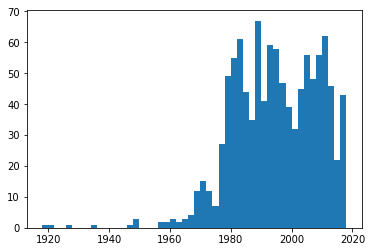

In [108]:
# Year information (All)
print('{} records have an associated year in the publication info (Plotted below)'.format(len(year_all_dict)))
plt.hist(year_all_dict.values(), bins=50)

854 records (excluding books) have an associated year in the publication info (Plotted below)


(array([ 1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  3.,  0.,  0.,  0.,  2.,  1.,  3.,  2.,  3.,  4., 12.,
        15., 12.,  7., 26., 43., 52., 56., 39., 32., 45., 30., 49., 51.,
        41., 27., 22., 37., 35., 31., 46., 40., 29., 17., 37.]),
 array([1918., 1920., 1922., 1924., 1926., 1928., 1930., 1932., 1934.,
        1936., 1938., 1940., 1942., 1944., 1946., 1948., 1950., 1952.,
        1954., 1956., 1958., 1960., 1962., 1964., 1966., 1968., 1970.,
        1972., 1974., 1976., 1978., 1980., 1982., 1984., 1986., 1988.,
        1990., 1992., 1994., 1996., 1998., 2000., 2002., 2004., 2006.,
        2008., 2010., 2012., 2014., 2016., 2018.]),
 <a list of 50 Patch objects>)

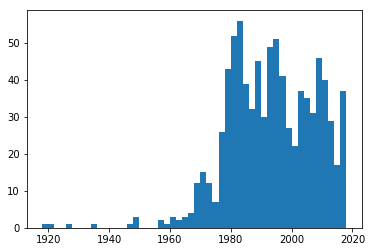

In [109]:
# Year information (No books)
print('{} records (excluding books) have an associated year in the publication info (Plotted below)'.format(len(year_nobook_dict)))
plt.hist(year_nobook_dict.values(), bins=50)

In [110]:
journal_df = pd.DataFrame(journal_list)
unique_journals = journal_df[0].value_counts()
print('{} records have a journal title, of which there are {} unique journals. Of which journals which appear the most are:'.format(len(journal_list), len(unique_journals)))
unique_journals[:20]

977 records have a journal title, of which there are 140 unique journals. Of which journals which appear the most are:


Nucl.Phys.A                                211
Phys.Lett.B                                 99
Phys.Rev.D                                  39
Nucl.Phys.B                                 38
Astrophys.J.                                37
Lect.Notes Phys.                            33
Phys.Rev.Lett.                              32
Nuovo Cim.A                                 27
Phys.Rept.                                  23
Nucl.Phys.B Proc.Suppl.                     23
Eur.Phys.J.C                                20
Nucl.Instrum.Meth.A                         17
Int.J.Mod.Phys.A                            16
Camb.Monogr.Part.Phys.Nucl.Phys.Cosmol.     13
PoS                                         13
World Sci.Lect.Notes Phys.                  11
Front.Phys.                                 11
JETP Lett.                                  10
JHEP                                        10
Int.Ser.Monogr.Phys.                        10
Name: 0, dtype: int64

# Please ignore after this

### Investiagte non-existent "cited" articles

In [26]:
non_overlapping = np.setdiff1d(np.union1d(records.oldRef.unique(), legacy.recID.unique()), np.intersect1d(records.oldRef.unique(), legacy.recID.unique()))
non_overlapping = non_overlapping[1:] # Remove entry for Zero

In [27]:
print('List from Legacy machine and from ES queries has {} non-overlapping records'.format(len(non_overlapping)))

List from Legacy machine and from ES queries has 5289 non-overlapping records


In [50]:
cited_in_dump_but_not_bibrank = []
cited_in_bibrank_but_not_dump = []
for article in non_overlapping:
    if len(records[records.oldRef == article]) != 0:
        cited_in_dump_but_not_bibrank.append(article)
    if len(legacy[legacy.recID == article]) != 0:
        cited_in_bibrank_but_not_dump.append(article)

In [100]:
cited_in_bibrank = legacy_indexed.loc[cited_in_bibrank_but_not_dump]

In [101]:
cited_in_dump = pd.DataFrame(records.oldRef.value_counts()[cited_in_dump_but_not_bibrank])
cited_in_dump.columns = ['Citation_Difference']

## Miscellaneous Stuff

In [62]:
f = core_articles_with_loss_ext.reindex(exist_list)
f = f[~f.Citation_Difference.isna()]

In [63]:
c = core_articles_with_loss_ext.Citation_Difference.value_counts()
sum(c[-6:])

2073

In [64]:
f[f.Citation_Difference < -5]

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
299778,-1159.0,1478.0,319.0
181166,-924.0,1728.0,804.0
279039,-470.0,821.0,351.0
794379,-445.0,508.0,63.0
640063,-351.0,412.0,61.0
744400,-342.0,342.0,0.0
706151,-322.0,338.0,16.0
656250,-315.0,484.0,169.0
618647,-310.0,330.0,20.0


In [65]:
top_200_lost_core= f.iloc[:200].index

In [66]:
# PLEASE ONLY RUN ONCE
if 'top_200_df' in locals():
    del top_200_df

for rid in top_200_lost_core:
    one_of_the_200 = records[(records.oldRef == rid) | (records.newRef == rid)]
    
    if 'top_200_df' in locals():
        top_200_df = top_200_df.append(one_of_the_200)
    else:
        top_200_df = one_of_the_200

In [135]:
top_200_df.to_csv('top_200_core_lost_citation_records-NEWAUG2018.csv')

In [139]:
f.iloc[0:200].to_csv('top_200_core_lost_citations_recids-NEWAUG2018.csv')

In [67]:
f.iloc[:200]

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
299778,-1159.0,1478.0,319.0
181166,-924.0,1728.0,804.0
279039,-470.0,821.0,351.0
794379,-445.0,508.0,63.0
640063,-351.0,412.0,61.0
744400,-342.0,342.0,0.0
706151,-322.0,338.0,16.0
656250,-315.0,484.0,169.0
618647,-310.0,330.0,20.0


In [32]:
top_200_lost_core

Int64Index([ 299778,  181166,   54961,  279039,  533044, 1245018,    9113,
             656250,  640063,  706151,
            ...
             809240,  809241,  805478,  809429,  809430,  800171,  811410,
             809232,  809225,  809217],
           dtype='int64', name='recID', length=200)

In [39]:
records[(records.newRef == 809217)]

,recID,oldRef,newRef,metaData


In [151]:
len(exist_list)

149056

In [152]:
len(not_exist_list)

6504